In [12]:
# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model
!pip install split-folders
import splitfolders

import os

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

In [7]:
# Constants
malevis_dir = "/home/odesa/Desktop/EBRAR/malevis_train_val_300x300"
TRAIN_DIR = "/home/odesa/Desktop/EBRAR/malevis300/train"
TEST_DIR = "/home/odesa/Desktop/EBRAR/malevis300/test"
VAL_DIR = "/home/odesa/Desktop/EBRAR/malevis300/val"
SIZE = (200, 200)
COLOR_MODE = "rgb"

In [6]:
splitfolders.ratio(os.path.join(malevis_dir, "train"), 
                       "malevis300/",
                       seed = 1337, 
                       ratio = (0.8, 0, 0.2), 
                       group_prefix = None, 
                       move = False)

Copying files: 9100 files [00:04, 2140.10 files/s]


In [8]:
# Create generators based on the preprocessing requirements of the CNN architecture.
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=cnns.xception.preprocess_input)
test_gen  = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=cnns.xception.preprocess_input)
val_gen   = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=cnns.xception.preprocess_input)

# Read images from the directories
train_images = train_gen.flow_from_directory(
            directory=TRAIN_DIR,
            target_size=SIZE,
            color_mode=COLOR_MODE,
            class_mode='categorical',
            classes=sorted([i for i in os.listdir(TRAIN_DIR) if i != "Other"]),
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training',
)

val_images = val_gen.flow_from_directory(
            directory=VAL_DIR,
            target_size=SIZE,
            classes=sorted([i for i in os.listdir(VAL_DIR) if i != "Other"]),
            color_mode=COLOR_MODE,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
)

test_images = test_gen.flow_from_directory(
            directory=TEST_DIR,
            target_size=SIZE,
            color_mode=COLOR_MODE,
            classes=sorted([i for i in os.listdir(TEST_DIR) if i != "Other"]),
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.


In [14]:
xception = cnns.Xception(include_top=False, input_shape=(200, 200, 3))

#Marks layer trainable or not
for layer in xception.layers[:100]:
    layer.trainable = False

for layer in xception.layers[100:]:
    layer.trainable = True
    
x = Flatten()(xception.output)

x = Dense(1000, activation='relu')(x)
predictions = Dense(25, activation = 'softmax')(x)

model = Model(inputs = xception.input, outputs = predictions)

model.compile(SGD(learning_rate=0.01, momentum= 0.8), loss="categorical_crossentropy", metrics=['accuracy'])
history = model.fit(train_images, batch_size=5, epochs=60, validation_data=val_images, callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True
                                        )])

Epoch 1/60


2023-06-13 21:28:00.991789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


219/219 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.8703

2023-06-13 21:33:02.391045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


219/219 [==============================] - 399s 2s/step - loss: 0.4851 - accuracy: 0.8703 - val_loss: 0.4842 - val_accuracy: 0.8746
Epoch 2/60
219/219 [==============================] - 390s 2s/step - loss: 0.0600 - accuracy: 0.9829 - val_loss: 0.2669 - val_accuracy: 0.9377
Epoch 3/60
219/219 [==============================] - 388s 2s/step - loss: 0.0131 - accuracy: 0.9963 - val_loss: 0.2648 - val_accuracy: 0.9451
Epoch 4/60
219/219 [==============================] - 390s 2s/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.2363 - val_accuracy: 0.9484
Epoch 5/60
219/219 [==============================] - 389s 2s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.2563 - val_accuracy: 0.9457
Epoch 6/60
219/219 [==============================] - 389s 2s/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.2477 - val_accuracy: 0.9479
Epoch 7/60
219/219 [==============================] - 389s 2s/step - loss: 7.0893e-04 - accuracy: 0.9999 - val_loss: 0.2467 - val_accuracy: 0.9487
Epoch 

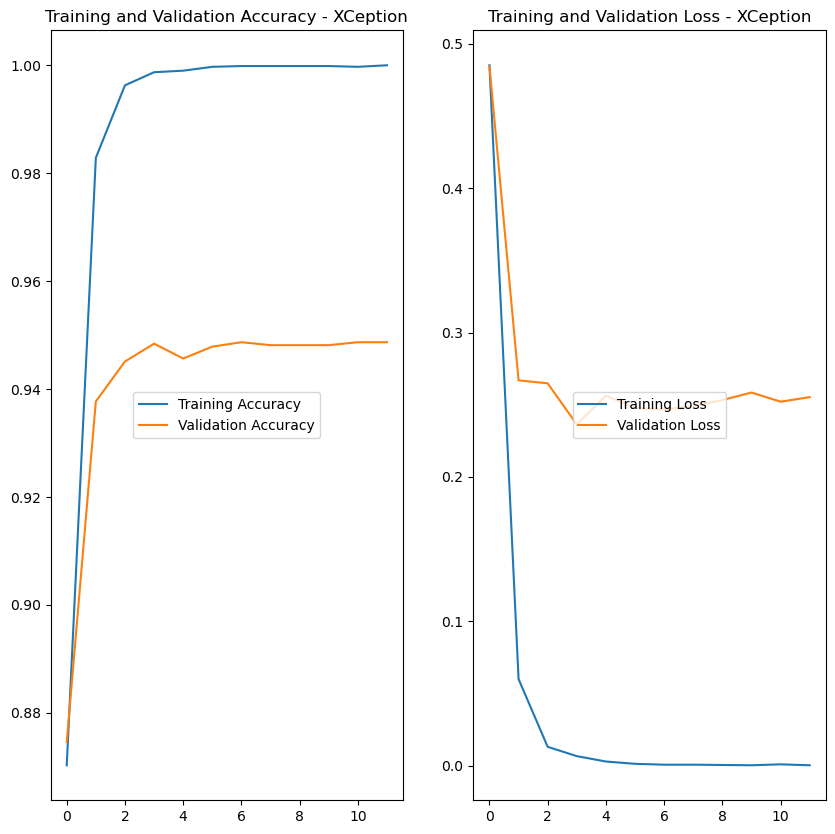

In [17]:
import matplotlib.pyplot as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center')
plt.title('Training and Validation Accuracy - XCeption')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center')
plt.title('Training and Validation Loss - XCeption')
plt.show()

In [18]:
predictions = model.predict(test_images)
predictions = list(map(np.argmax, predictions))

2023-06-13 22:50:17.944281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


55/55 [==============================] - 74s 1s/step


In [19]:
print(classification_report(test_images.labels, predictions, target_names=list(test_images.class_indices.keys())))

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.84      0.83      0.83        70
     Allaple       0.96      1.00      0.98        70
   Amonetize       0.97      0.96      0.96        70
      Androm       0.92      0.86      0.89        70
     Autorun       0.90      0.89      0.89        70
   BrowseFox       0.97      0.99      0.98        70
      Dinwod       1.00      1.00      1.00        70
        Elex       0.95      1.00      0.97        70
      Expiro       0.82      0.90      0.86        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.90      0.87      0.88        70
 InstallCore       0.99      0.99      0.99        70
   MultiPlug       0.99      0.97      0.98        70
  Neoreklami       1.00      0.99      0.99        70
      Neshta       0.73    